https://www.youtube.com/watch?v=kCc8FmEb1nY

In [1]:
import torch
from torch import nn
from torch.nn import functional as F


torch.manual_seed(123)

In [2]:
import pandas as pd
from tqdm.notebook import tqdm

## get dataset

In [3]:
# !curl https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt > datasets/shakespeare.txt
# !curl https://www.gutenberg.org/cache/epub/5186/pg5186.txt > datasets/kalevala-en.txt
# !curl https://www.gutenberg.org/cache/epub/7000/pg7000.txt > datasets/kalevala-fi.txt

In [4]:
with open('datasets/kalevala-fi.txt') as f:
    text = f.read()[2329:]
    
print(len(text))
print(text[:1000])

610233
  Ensimmäinen runo


  Mieleni minun tekevi,
  aivoni ajattelevi
  lähteäni laulamahan,
  saa'ani sanelemahan,
  sukuvirttä suoltamahan,
  lajivirttä laulamahan.
  Sanat suussani sulavat,
  puhe'et putoelevat,
  kielelleni kerkiävät,
  hampahilleni hajoovat.
  Veli kulta, veikkoseni,
  kaunis kasvinkumppalini!
  Lähe nyt kanssa laulamahan,
  saa kera sanelemahan
  yhtehen yhyttyämme,
  kahta'alta käytyämme!
  Harvoin yhtehen yhymme,
  saamme toinen toisihimme
  näillä raukoilla rajoilla,
  poloisilla Pohjan mailla.
  Lyökämme käsi kätehen,
  sormet sormien lomahan,
  lauloaksemme hyviä,
  parahia pannaksemme,
  kuulla noien kultaisien,
  tietä mielitehtoisien,
  nuorisossa nousevassa,
  kansassa kasuavassa:
  noita saamia sanoja,
  virsiä virittämiä
  vyöltä vanhan Väinämöisen,
  alta ahjon Ilmarisen,
  päästä kalvan Kaukomielen,
  Joukahaisen jousen tiestä,
  Pohjan peltojen periltä,
  Kalevalan kankahilta.
  Niit' ennen isoni lauloi
  kirvesvartta vuollessansa;
  niitä äitini 

In [5]:
chars = sorted(set(text))

stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join(itos[i] for i in l)

print(chars)
print(enc := list(encode('Väinämöinen')))
print(decode(enc))

['\n', ' ', '!', '"', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ä', 'ä', 'ö']
[49, 80, 61, 66, 80, 65, 81, 61, 66, 57, 66]
Väinämöinen


## bigram model

In [6]:
# hyperparams

BATCH_SIZE = 32
BLOCK_SIZE = 8
MAX_ITERS = 10000
EVAL_INTERVAL = 300
LEARNING_RATE = 1e-2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200

TRAIN_SPLIT = 0.9

In [7]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(TRAIN_SPLIT * len(data))
train_data = data[:n]
val_data = data[n:]

In [8]:


def get_batch(
    split, 
    batch_size=BATCH_SIZE, 
    block_size=BLOCK_SIZE
):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x, y




In [9]:


class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        
        # idx, targets are (B, T) tensors
        logits = self.token_embedding_table(idx)  # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx here is apparently a (B, T) tensor of indices "in the current context"
        for _ in range(max_new_tokens):
            logits, (loss) = self(idx)
            logits = logits[:, -1, :]  # take the last time step, "becomes (B, C)"
            probs = F.softmax(logits, dim=-1)  # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            
            # concatenate sample to running, becomes (B, T+1 )
            idx = torch.cat((idx, idx_next), dim=1)  
        return idx

m = BigramLanguageModel(vocab_size=len(chars))
m = m.to(DEVICE)


In [10]:
xb, yb = get_batch('train')
logits, loss = m(xb, yb)

idx = torch.zeros((1, 1), dtype=torch.long)
gentext = decode(m.generate(idx, max_new_tokens=1000)[0].tolist())
print(f'zero train (loss {loss.item()}):')

print(gentext)

zero train (loss 4.895671844482422):

5td)$2r%(Kj.5F!!ä5zL.b!4DBU*j a:S3IGpVe3%0U6ä91ö106F3J5n8T9RH%RgDc@s9(v)3@OöJn*H%8pqUDqabU6
/C/N@Ewzepä1qUt"Fe!xÄS@@@ÄOmn8q4rFk3GfäFMF!8D@Tzfrso(;,E;h8$0mA?h;DfMNrFRCQÄWCNJ0t!K'MiCz3-z''syw-WGsu*JRnLcd

.e17$z)-Rc*SÄrWqcVQÄrä?8$OQÄU7cs6r(6AG5ri*lStdbe3?NtiEqö;Q P'" NrgdwyYgsYVqC179?%vVIt'IC.baFJ7iz0d
k';7gw-ä?g2rF6eRW89R8fswLc1UC.z$tJb?;,(pRä'"(fÄr?;71O1äe89R*SLo7g
250EuGp8'j2v$://w$CuXFm689lÄ4T7Ik'ITR,jL.bP'Mh8YOm5rND8AQ9jxM5QSdzyvLqS5RK$uBmA?htF,U6c89D(v,GpEp4l$..*.3$zcxTv5V; Kyw4fhxÄ0kVkYILXo13z3ab!ä%dakgzU6e7iPf2@p8äx-9PD$t9TjY/Mö
6FfDH(zdmö:4@Tv:bökVu8M,Y!n8DC
H"DCU
dfqF 9SehvR*@@aBX2%SQ(5O1Gf2$0XqR8$tGjqC,ö$-iH*äK)uPQSb )J7WMn:,HBwzhAGph, nC/ämmA*n9SvfCd'ijRUgdAEpFH, O;,A6Kö09OJ8IÄ-,JWöYöMz)lpN@s
du2QHEMie5sQbaBX; 87iCU1ORqc*.qN.pshU
jUQ!Pen7hUYaä:ElÄq9.vHx,:rde3BM%$8YuQtj"Äv-9c*1D$n-n9.1I'ev0)dzTlba9lv5!-X;YafizbBa9VsC4n17bqC*oDlrFf89m0S1zz 3gnl"uKPUölnJb162CzhO;b KÄYjX@D%jxX/gbb BKydl.74u,1ä
äCijV,i
qkRxq.IL"Dy10keÄN@9rM8MlPzArxOrwM9äd6euK;

In [11]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in 'train', 'val':
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

### let's train

In [12]:
optimizer = torch.optim.AdamW(m.parameters(), lr=LEARNING_RATE)

_val_losses = []
for i in tqdm(range(MAX_ITERS)):
    if i % EVAL_INTERVAL == 0:
        est_loss = estimate_loss(m)
        print(f"{i}: {est_loss['train']=} / {est_loss['val']=}")
        _val_losses.append({'i': i, 'loss': est_loss['val'].item()})
    
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

0: est_loss['train']=tensor(4.9273) / est_loss['val']=tensor(4.9221)
300: est_loss['train']=tensor(2.7050) / est_loss['val']=tensor(3.1170)
600: est_loss['train']=tensor(2.4092) / est_loss['val']=tensor(2.9618)
900: est_loss['train']=tensor(2.3575) / est_loss['val']=tensor(2.9485)
1200: est_loss['train']=tensor(2.3284) / est_loss['val']=tensor(2.9676)
1500: est_loss['train']=tensor(2.3329) / est_loss['val']=tensor(2.9871)
1800: est_loss['train']=tensor(2.3238) / est_loss['val']=tensor(2.9838)
2100: est_loss['train']=tensor(2.3142) / est_loss['val']=tensor(3.0094)
2400: est_loss['train']=tensor(2.3082) / est_loss['val']=tensor(3.0048)
2700: est_loss['train']=tensor(2.3185) / est_loss['val']=tensor(3.0362)
3000: est_loss['train']=tensor(2.3069) / est_loss['val']=tensor(3.0272)
3300: est_loss['train']=tensor(2.3163) / est_loss['val']=tensor(3.0678)
3600: est_loss['train']=tensor(2.3124) / est_loss['val']=tensor(3.0502)
3900: est_loss['train']=tensor(2.3156) / est_loss['val']=tensor(3.0547

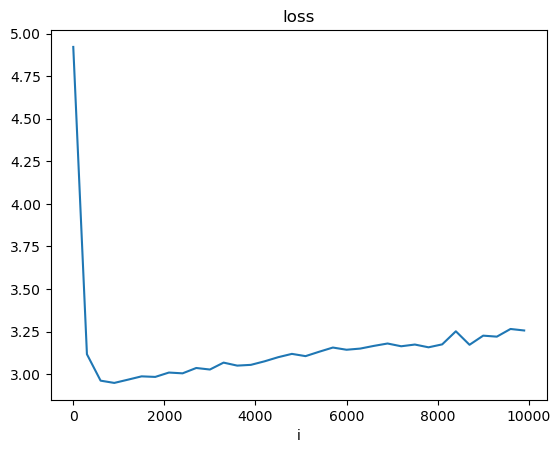

In [18]:
pd.DataFrame(_val_losses).set_index('i')['loss'].plot(title='loss');

In [15]:
idx = torch.zeros((1, 1), dtype=torch.long)
gentext = decode(m.generate(idx, max_new_tokens=1000)[0].tolist())
print(f'after train (loss {loss.item()}):')

print(gentext)

after train (loss 2.408484697341919):

  tstahjan
  virtii tsouohastava,
 tka,
 Ila t va:
 Vekuo sa laiviia   le,
 olastan."
 sini;
 Lanunttkähajon!
  ppestämä mä "Oinn tetolattetoi Kuonätttohatukkantun  kansi   relloin i:
 kahäi  letattai,
 lväihihenosaveha  mant to'uvopi;
 Pon o,
 ki,
 ein tatuua
 Viljela,
 lla.
 ksale,
 kemäkomä,
 poväkituoan kksuaikusettauvahelosaasilenuon tanonhana,
 kä,
 poinoi   Illatuhistanuhtaki!
 sta, opaneman,
 lönttuallien iiritatöinelanka  st,
 stänyätisen ha:
 n,
 Siäksissäisa  kekopeanksi t mekskali
 oha
 eniäeilemä   anoie eltel pumämä  Lukkäsi  könein.
 mino voilealevahat  o  kkuuksiotis  ha'  a:
  Anäi,
 latauuolltu letikiralma,
 Kus Ko    himohäkoaupa "Poronäkoinerason käkutäämi Vä
 Väitullulti si juurehepasa,
 kui site  kanuhää, seksan  ollen!
 verala  oust tköikalelen viitun Vasisa  tä surein:
 vat esisin  kki
 koi,  Kuonnteaaua majykun!"Kukalevai, taa  pi rarjala puikaeii   kan Sasesi tanai kuouon llie maoni   ehäkansanankyii ki ka lan Lekynhun ka

In [16]:
# continue from https://youtu.be/kCc8FmEb1nY?t=2297